In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import math

#Import Neural Network as a classifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
from sklearn.metrics import recall_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
from sklearn.metrics import precision_score

In [27]:
path = '/home/malpizar/Documents/MultipleScattering/backup/'
file = 'RecoilsData.csv'

df = pd.read_csv(path + file)

#drop events with no recoils at all
df = df[df['ar40recoils'] != 0]

#drop rows with the value -99999, these are outliers
df = df.drop(index=df[df.eq(-99999).any(axis=1)].index)

df.head()
print(df.shape)

(1209, 25)


In [28]:
#drop the variable used to make the flags for multiple recoils
df = df.drop(['ar40recoils'], axis=1) 
print(df.shape)

(1209, 24)


In [29]:
# Count the occurrences of each value in multiplerecoils
value_counts = df['multiplerecoils'].value_counts()
print(value_counts)

# Drop rows with multiplerecoils to make it more even between multiple and single
#df = df.drop(df[df['multiplerecoils'] == 1].head(659).index) #50-50
#df = df.drop(df[df['multiplerecoils'] == 1].head(659).index)

# Get a random permutation of the DataFrame's index
random_order = np.random.RandomState(seed=42).permutation(df.index)

# Reorder the DataFrame randomly using the random permutation
df = df.loc[random_order]

print("Df shuffled.")

1    934
0    275
Name: multiplerecoils, dtype: int64
Df shuffled.


In [30]:
#dependent variable that will be predicted
var = 'multiplerecoils'

X = df.drop([var], axis=1)

# Select the dependent variable
y = df[var] 

print(X.shape)
print(y.shape)

(1209, 23)
(1209,)


In [31]:
# Splitting the dataset to Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(967, 23)
(967,)
(242, 23)
(242,)


In [32]:
# Standardize the features (optional but recommended for neural networks)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [33]:
# Create the Dense neural network model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on new data
#new_data = np.random.rand(5, 24)
#new_data = scaler.transform(new_data)
#predictions = model.predict(new_data)
#print("Predictions:")
#print(predictions)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1536      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,649
Trainable params: 3,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
28/28 [==============================] - 1s 11ms/step - loss: 3458066.2500 - accuracy: 0.6471 - val_loss: 323825.0000 - val_accuracy: 0.7629
Epoch 2/20
28/28 [==============================] - 0s 5ms/step - loss: 1391164.3750 - accuracy: 0.6931 - val_loss: 2020379.3750 - val_accuracy: 0.3196
Epoch 3/20
2

In [34]:
# Make predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

8/8 [==============================] - 0s 2ms/step


In [35]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.77686


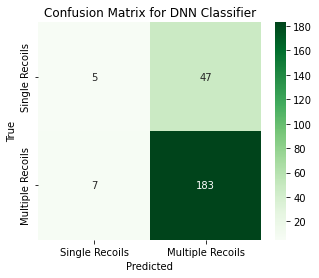

[0 1]


In [52]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
#class_labels = df[var].unique()
#class_labels = ['multiple recoils', 'single recoils']

#print(df[var].unique())

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')

# Add a legend
#plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
#plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
tick_marks = np.arange(len(df[var].unique())) + 0.5
plt.xticks(tick_marks, ['Single Recoils', 'Multiple Recoils'])
plt.yticks(tick_marks, ['Single Recoils', 'Multiple Recoils'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for DNN Classifier')

# Display the plot
plt.show()
print(np.arange(2))

In [37]:
#calculate recall, precision and F1 score

rec = recall_score(y_test, y_pred)#, average='binary')
#The recall is intuitively the ability of the classifier to find all the positive samples.
pres = precision_score(y_test, y_pred)#, average='binary')
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
F1_score = 2/((1/rec) + (1/pres))
#F1 is the harmmonic mean between recall and precision

#weighted metrics
wrec = recall_score(y_test, y_pred, average='weighted')
wpres = precision_score(y_test, y_pred, average='weighted')
wF1_score = 2/((1/wrec) + (1/wpres))

print("The recall is: ", rec)
print("The precision is: ", pres)
print("The F1-score is: ", F1_score)

print("\nThe weighted recall is: ", wrec)
print("The weighted precision is: ", wpres)
print("The weighted F1-score is: ", wF1_score)

The recall is:  0.9631578947368421
The precision is:  0.7956521739130434
The F1-score is:  0.8714285714285714

The weighted recall is:  0.7768595041322314
The weighted precision is:  0.7142172715295244
The weighted F1-score is:  0.7442225436806964


In [38]:
#metrics by hand

tn, fp, fn, tp = cm.ravel()

err = (fp + fn)/(fp + fn + tn + tp)
acc = (tp + tn)/(fp + fn + tn + tp)
re = tp/(tp + fn)
sp = tn/(tn + fp)
prec = tp/(tp + fp)
fpr = fp/(tn + fp)
mcc = ((tp*tn) - (fp*fn))/math.sqrt((tp + fp)*(tp + tn)*(tn + fp)*(tn + fn))
F1 = 2/((1/re) + (1/prec))

print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)
print("True Positive:", tp)
print("\nError rate:", err)
print("Accuracy:", acc)
print("Recall:", re) #sensitivity, true positive rate
print("Specificity:", sp) #true negative rate
print("Precision:", prec) #positive predictive value
print("False positive rate:", fpr)
print("Mathews correlation coefficient:", mcc)
print("F1 score:", F1)

True Negative: 5
False Positive: 47
False Negative: 7
True Positive: 183

Error rate: 0.2231404958677686
Accuracy: 0.7768595041322314
Recall: 0.9631578947368421
Specificity: 0.09615384615384616
Precision: 0.7956521739130434
False positive rate: 0.9038461538461539
Mathews correlation coefficient: 0.1128138650361989
F1 score: 0.8714285714285714


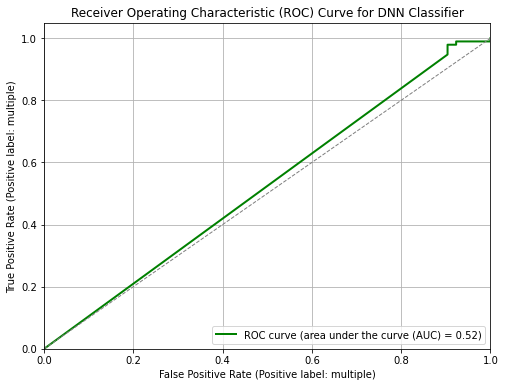

In [43]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='g', lw=2, label='ROC curve (area under the curve (AUC) = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Positive label: multiple)')
plt.ylabel('True Positive Rate (Positive label: multiple)')
plt.title('Receiver Operating Characteristic (ROC) Curve for DNN Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()